In [1]:
!pip install darts


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.9/846.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 

In [2]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

In [3]:
from darts import TimeSeries

In [4]:
def split_train_test(df,max_date_train,min_date_test):
  treino = df.query("Data <= @max_date_train")
  teste= df.query("Data >= @min_date_test")
  return treino,teste

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def calculate_arima_metrics(observed_values, predicted_values):
    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(observed_values, predicted_values))

    # MSE (Mean Squared Error)
    mse = mean_squared_error(observed_values, predicted_values)

    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(observed_values, predicted_values)

    # MAPE (Mean Absolute Percentage Error)
    def mean_absolute_percentage_error(observed_values, predicted_values):
        return np.mean(np.abs((observed_values - predicted_values) / observed_values)) * 100
    mape = mean_absolute_percentage_error(observed_values, predicted_values)

    # R² (Coeficiente de Determinação)
    r2 = r2_score(observed_values, predicted_values)

    # MASE (Mean Absolute Scaled Error) - Necessário calcular os erros do modelo de benchmark
    naive_forecast = np.roll(observed_values, 1)  # Utilizando previsão ingênua (shift de 1)
    naive_errors = np.abs(observed_values - naive_forecast)
    mase = np.mean(np.abs(observed_values - predicted_values) / naive_errors)

    # sMAPE (Symmetric Mean Absolute Percentage Error)
    def symmetric_mean_absolute_percentage_error(observed_values, predicted_values):
        return np.mean(2 * np.abs(observed_values - predicted_values) / (np.abs(observed_values) + np.abs(predicted_values))) * 100
    smape = symmetric_mean_absolute_percentage_error(observed_values, predicted_values)

    return rmse, mse, mae, mape, r2, mase, smape

import psutil
memoria_usada = []
def capturar_uso_memoria():
    # Captura o uso de memória RAM atual
    uso_memoria = psutil.virtual_memory().used
    memoria_usada.append(uso_memoria)

# LSD

In [6]:
df = pd.read_csv('https://docs.google.com/uc?export=download&id=11Wv1SFE_O0dGeYMWEXQpGOyd11Z2v41J')
df['Data'] = pd.to_datetime(df['Data'])
data = df['total_w']

In [7]:
import pandas as pd
import xarray as xr

# Supondo que você tenha um DataFrame chamado df com as colunas 'Data' e 'total_w'

# Primeiro, converta a coluna 'Data' para o tipo datetime
df['Data'] = pd.to_datetime(df['Data'])

# Em seguida, defina o índice do DataFrame como a coluna 'Data'
df.set_index('Data', inplace=True)

# Crie o objeto TimeSeries (DataArray) a partir do DataFrame
time_series = xr.DataArray(df['total_w'])

# O objeto time_series agora é um DataArray onde as datas são os índices.


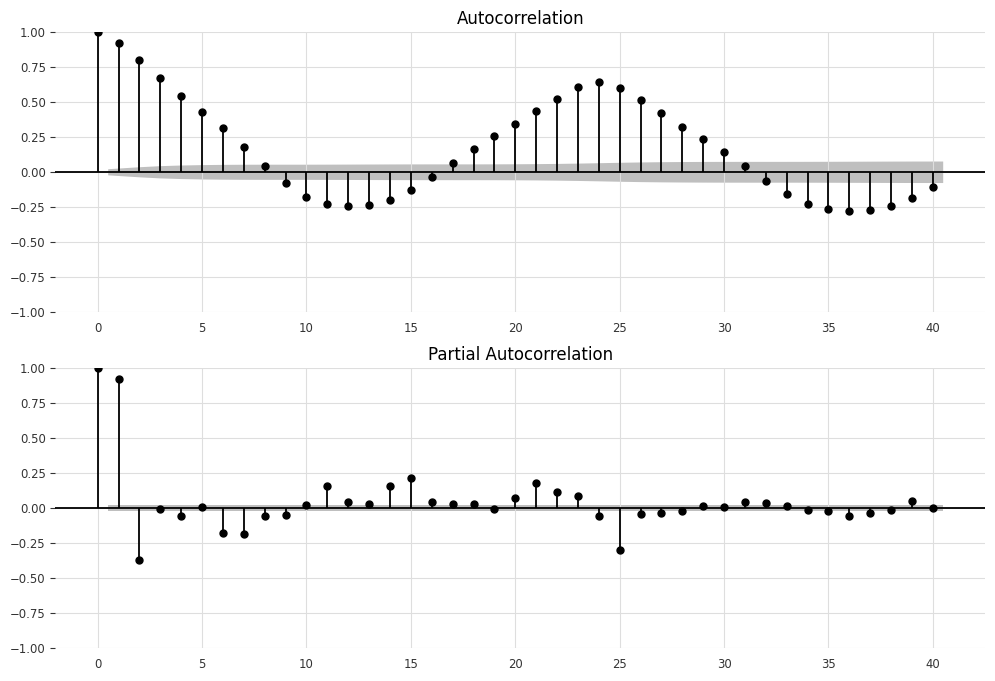

In [8]:

# Plotar gráficos de autocorrelação e autocorrelação parcial
fig, ax = plt.subplots(2,1,figsize=(12,8))
plot_acf(data, ax=ax[0])
plot_pacf(data, ax=ax[1])
plt.show()


In [9]:
train,test = split_train_test(df,'2023-07-19 23:00:00','2023-07-20 00:00:00')

In [10]:
from darts.datasets import AirPassengersDataset
from darts.models import ARIMA
from darts.utils.timeseries_generation import datetime_attribute_timeseries
series_ts = TimeSeries.from_series(train['total_w'])
series = series_ts
future_cov = datetime_attribute_timeseries(series, "hour", cyclic=True, add_length=test.shape[0])
# define ARIMA parameters
model = ARIMA(p=0, d=1, q=0)
model.fit(series, future_covariates=future_cov)
capturar_uso_memoria()
pred = model.predict(test.shape[0], future_covariates=future_cov)
pred.values()

array([[18341.64949743],
       [18213.20083443],
       [18301.74087234],
       [18601.23575389],
       [19091.27539784],
       [19738.46441229],
       [20498.69793543],
       [21320.16730901],
       [22146.89075275],
       [22922.5284302 ],
       [23594.22191544],
       [24116.19640746],
       [24452.88020726],
       [24581.32887026],
       [24492.78883235],
       [24193.2939508 ],
       [23703.25430685],
       [23056.0652924 ],
       [22295.83176926],
       [21474.36239568],
       [20647.63895193],
       [19872.00127449],
       [19200.30778925],
       [18678.33329722],
       [18341.64949743],
       [18213.20083443],
       [18301.74087234],
       [18601.23575389],
       [19091.27539784],
       [19738.46441229],
       [20498.69793543],
       [21320.16730901],
       [22146.89075275],
       [22922.5284302 ],
       [23594.22191544],
       [24116.19640746],
       [24452.88020726],
       [24581.32887026],
       [24492.78883235],
       [24193.2939508 ],


In [11]:
pred.values().shape

(456, 1)

In [12]:
# Exemplo de uso:
observed_values = test['total_w']
predicted_values = pred.values().flatten()
rmse, mse, mae, mape, r2, mase, smape = calculate_arima_metrics(observed_values, predicted_values)
print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)
print("MAPE:", mape)
print("R²:", r2)
print("MASE:", mase)
print("sMAPE:", smape)
print('Memoria RAM:',max(memoria_usada))

RMSE: 2942.1890073698023
MSE: 8656476.155087702
MAE: 2387.4711915360494
MAPE: 11.299024353242055
R²: 0.3375596816805385
MASE: inf
sMAPE: 10.914777237691903
Memoria RAM: 1257295872


# CEEI

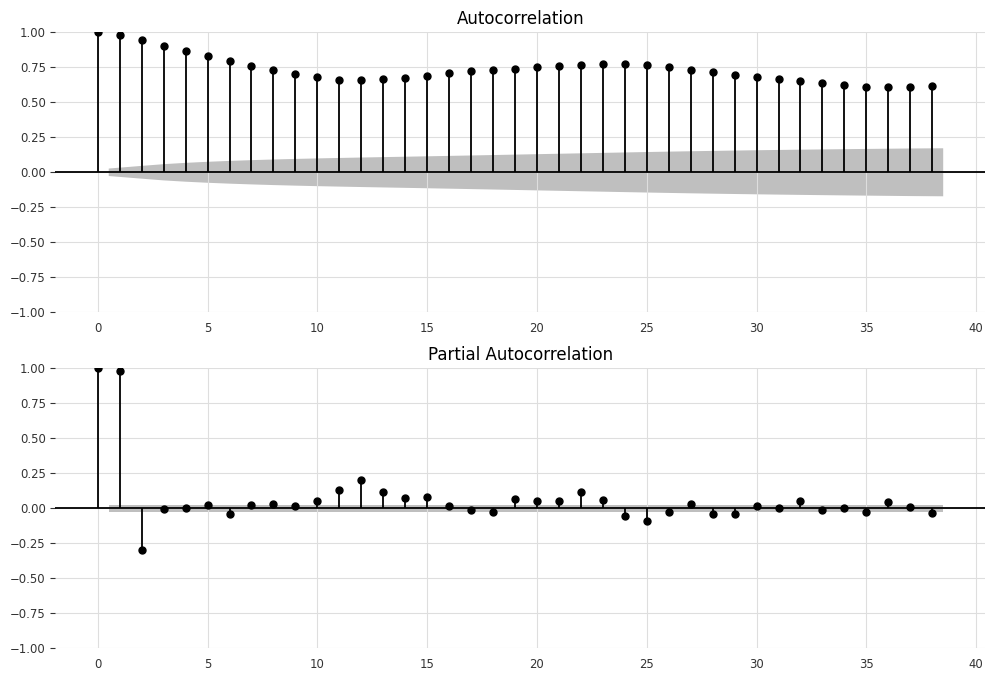

In [6]:
df = pd.read_csv('https://docs.google.com/uc?export=download&id=1-O64qB-YGpzpJ3QmRHTb6MxcqZYZRMdC')

df['Data'] = pd.to_datetime(df['Data'])
data = df['total_w']
import pandas as pd
import xarray as xr

# Supondo que você tenha um DataFrame chamado df com as colunas 'Data' e 'total_w'

# Primeiro, converta a coluna 'Data' para o tipo datetime
df['Data'] = pd.to_datetime(df['Data'])

# Em seguida, defina o índice do DataFrame como a coluna 'Data'
df.set_index('Data', inplace=True)

# Crie o objeto TimeSeries (DataArray) a partir do DataFrame
time_series = xr.DataArray(df['total_w'])

# O objeto time_series agora é um DataArray onde as datas são os índices.
# Plotar gráficos de autocorrelação e autocorrelação parcial
fig, ax = plt.subplots(2,1,figsize=(12,8))
plot_acf(data, ax=ax[0])
plot_pacf(data, ax=ax[1])
plt.show()


In [7]:
train,test = split_train_test(df,'2023-07-31 23:00:00','2023-08-01 00:00:00')

In [8]:
from darts.datasets import AirPassengersDataset
from darts.models import ARIMA
from darts.utils.timeseries_generation import datetime_attribute_timeseries
series_ts = TimeSeries.from_series(train['total_w'])
series = series_ts
future_cov = datetime_attribute_timeseries(series, "hour", cyclic=True, add_length=test.shape[0])
# define ARIMA parameters
model = ARIMA(p=0, d=1, q=0)
model.fit(series, future_covariates=future_cov)
capturar_uso_memoria()
pred = model.predict(test.shape[0], future_covariates=future_cov)
pred.values()

array([[1912.35054451],
       [1912.41299101],
       [1917.12175371],
       [1926.15593821],
       [1938.89987977],
       [1954.48509982],
       [1971.84949138],
       [1989.80969987],
       [2007.14176674],
       [2022.66454029],
       [2035.32016916],
       [2044.24619314],
       [2048.83431846],
       [2048.77187196],
       [2044.06310926],
       [2035.02892477],
       [2022.28498321],
       [2006.69976316],
       [1989.33537159],
       [1971.37516311],
       [1954.04309624],
       [1938.52032268],
       [1925.86469382],
       [1916.93866983],
       [1912.35054451],
       [1912.41299101],
       [1917.12175371],
       [1926.15593821],
       [1938.89987977],
       [1954.48509982],
       [1971.84949138],
       [1989.80969987],
       [2007.14176674],
       [2022.66454029],
       [2035.32016916],
       [2044.24619314],
       [2048.83431846],
       [2048.77187196],
       [2044.06310926],
       [2035.02892477],
       [2022.28498321],
       [2006.699

In [9]:
observed_values = test['total_w']
predicted_values = pred.values().flatten()
rmse, mse, mae, mape, r2, mase, smape = calculate_arima_metrics(observed_values, predicted_values)
print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)
print("MAPE:", mape)
print("R²:", r2)
print("MASE:", mase)
print("sMAPE:", smape)
print('Memoria RAM:',max(memoria_usada))

RMSE: 638.1801413117236
MSE: 407273.8927646514
MAE: 494.0512260639399
MAPE: 44.610649851800595
R²: -0.49979951624756813
MASE: inf
sMAPE: 31.27005887229985
Memoria RAM: 1255972864


# CN

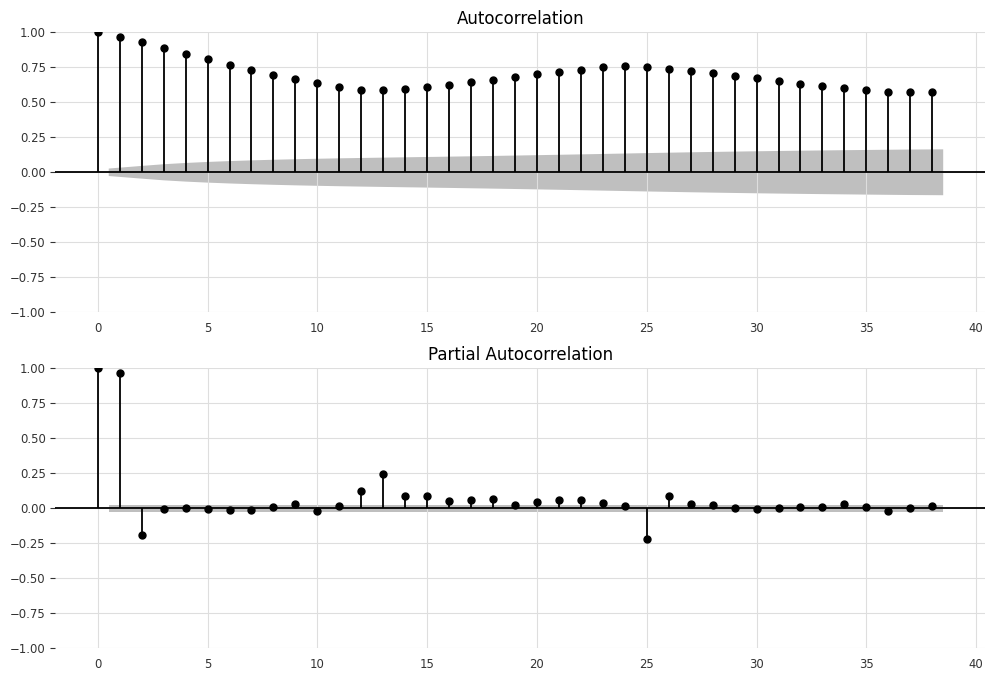

In [6]:
df = pd.read_csv('https://docs.google.com/uc?export=download&id=1-FpG1tqJgQJq0FVPozPvpzu-sO4n5zV3')

df['Data'] = pd.to_datetime(df['Data'])
data = df['total_w']
import pandas as pd
import xarray as xr

# Supondo que você tenha um DataFrame chamado df com as colunas 'Data' e 'total_w'

# Primeiro, converta a coluna 'Data' para o tipo datetime
df['Data'] = pd.to_datetime(df['Data'])

# Em seguida, defina o índice do DataFrame como a coluna 'Data'
df.set_index('Data', inplace=True)

# Crie o objeto TimeSeries (DataArray) a partir do DataFrame
time_series = xr.DataArray(df['total_w'])

# O objeto time_series agora é um DataArray onde as datas são os índices.
# Plotar gráficos de autocorrelação e autocorrelação parcial
fig, ax = plt.subplots(2,1,figsize=(12,8))
plot_acf(data, ax=ax[0])
plot_pacf(data, ax=ax[1])
plt.show()

In [7]:
train,test = split_train_test(df,'2023-07-31 23:00:00','2023-08-01 00:00:00')

In [8]:
from darts.datasets import AirPassengersDataset
from darts.models import ARIMA
from darts.utils.timeseries_generation import datetime_attribute_timeseries
series_ts = TimeSeries.from_series(train['total_w'])
series = series_ts
future_cov = datetime_attribute_timeseries(series, "hour", cyclic=True, add_length=test.shape[0])
# define ARIMA parameters
model = ARIMA(p=0, d=1, q=0)
model.fit(series, future_covariates=future_cov)
capturar_uso_memoria()
pred = model.predict(test.shape[0], future_covariates=future_cov)
pred.values()

array([[7784.02627756],
       [7769.7429626 ],
       [7766.58769273],
       [7774.77549438],
       [7793.74838238],
       [7822.21338578],
       [7858.23066164],
       [7899.34569212],
       [7942.75655585],
       [7985.5048742 ],
       [8024.67741993],
       [8057.60464877],
       [8082.0426245 ],
       [8096.32593945],
       [8099.48120932],
       [8091.29340768],
       [8072.32051968],
       [8043.85551628],
       [8007.83824042],
       [7966.72320994],
       [7923.31234621],
       [7880.56402785],
       [7841.39148213],
       [7808.46425329],
       [7784.02627756],
       [7769.7429626 ],
       [7766.58769273],
       [7774.77549438],
       [7793.74838238],
       [7822.21338578],
       [7858.23066164],
       [7899.34569212],
       [7942.75655585],
       [7985.5048742 ],
       [8024.67741993],
       [8057.60464877],
       [8082.0426245 ],
       [8096.32593945],
       [8099.48120932],
       [8091.29340768],
       [8072.32051968],
       [8043.855

In [9]:
observed_values = test['total_w']
predicted_values = pred.values().flatten()
rmse, mse, mae, mape, r2, mase, smape = calculate_arima_metrics(observed_values, predicted_values)
print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)
print("MAPE:", mape)
print("R²:", r2)
print("MASE:", mase)
print("sMAPE:", smape)
print('Memoria RAM:',max(memoria_usada))

RMSE: 834.5046625868019
MSE: 696398.0318791122
MAE: 685.5827166639205
MAPE: 9.234428122751858
R²: -0.058242406849145834
MASE: inf
sMAPE: 8.887836240376283
Memoria RAM: 1264664576


# SPLAB

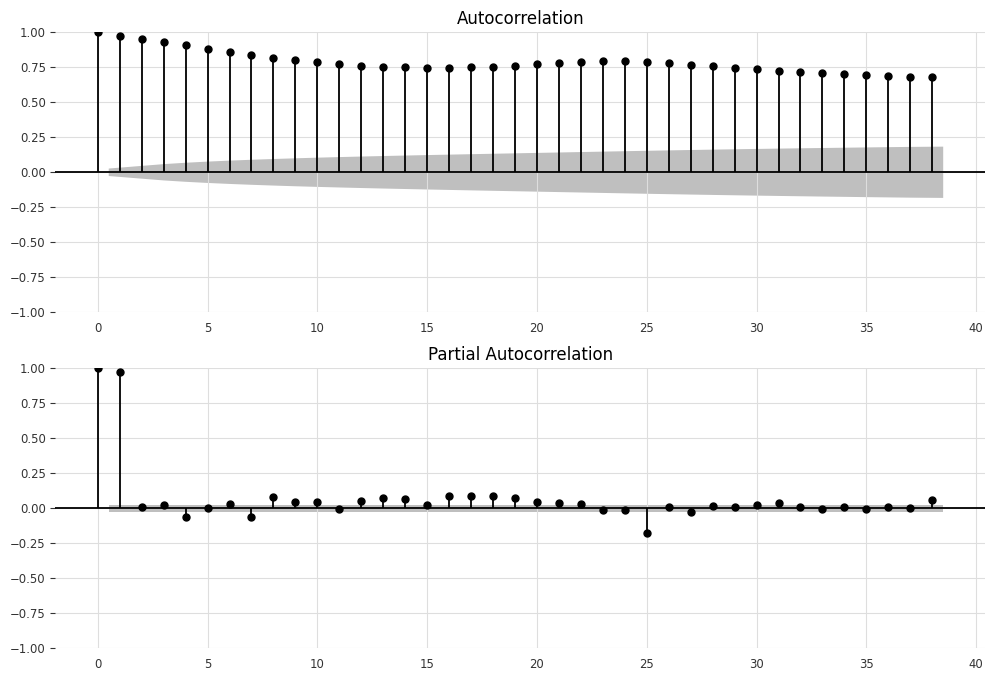

In [6]:
df = pd.read_csv('https://docs.google.com/uc?export=download&id=1-H_5m5gkZuZd4Nx33LxOBI9cm0Rox8bR')

df['Data'] = pd.to_datetime(df['Data'])
data = df['total_w']
import pandas as pd
import xarray as xr

# Supondo que você tenha um DataFrame chamado df com as colunas 'Data' e 'total_w'

# Primeiro, converta a coluna 'Data' para o tipo datetime
df['Data'] = pd.to_datetime(df['Data'])

# Em seguida, defina o índice do DataFrame como a coluna 'Data'
df.set_index('Data', inplace=True)

# Crie o objeto TimeSeries (DataArray) a partir do DataFrame
time_series = xr.DataArray(df['total_w'])

# O objeto time_series agora é um DataArray onde as datas são os índices.
# Plotar gráficos de autocorrelação e autocorrelação parcial
fig, ax = plt.subplots(2,1,figsize=(12,8))
plot_acf(data, ax=ax[0])
plot_pacf(data, ax=ax[1])
plt.show()

In [7]:
train,test = split_train_test(df,'2023-07-31 23:00:00','2023-08-01 00:00:00')

In [8]:
from darts.datasets import AirPassengersDataset
from darts.models import ARIMA
from darts.utils.timeseries_generation import datetime_attribute_timeseries
series_ts = TimeSeries.from_series(train['total_w'])
series = series_ts
future_cov = datetime_attribute_timeseries(series, "hour", cyclic=True, add_length=test.shape[0])
# define ARIMA parameters
model = ARIMA(p=0, d=1, q=0)
model.fit(series, future_covariates=future_cov)
capturar_uso_memoria()
pred = model.predict(test.shape[0], future_covariates=future_cov)
pred.values()

array([[2195.57297878],
       [2193.93865642],
       [2193.79610988],
       [2195.15505347],
       [2197.92287743],
       [2201.91095913],
       [2206.8475174 ],
       [2212.39613395],
       [2218.17867972],
       [2223.80108379],
       [2228.8801886 ],
       [2233.06986155],
       [2236.08458337],
       [2237.71890573],
       [2237.86145227],
       [2236.50250868],
       [2233.73468472],
       [2229.74660302],
       [2224.81004475],
       [2219.26142821],
       [2213.47888243],
       [2207.85647837],
       [2202.77737356],
       [2198.5877006 ],
       [2195.57297878],
       [2193.93865642],
       [2193.79610988],
       [2195.15505347],
       [2197.92287743],
       [2201.91095913],
       [2206.8475174 ],
       [2212.39613395],
       [2218.17867972],
       [2223.80108379],
       [2228.8801886 ],
       [2233.06986155],
       [2236.08458337],
       [2237.71890573],
       [2237.86145227],
       [2236.50250868],
       [2233.73468472],
       [2229.746

In [9]:
observed_values = test['total_w']
predicted_values = pred.values().flatten()
rmse, mse, mae, mape, r2, mase, smape = calculate_arima_metrics(observed_values, predicted_values)
print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)
print("MAPE:", mape)
print("R²:", r2)
print("MASE:", mase)
print("sMAPE:", smape)
print('Memoria RAM:',max(memoria_usada))

RMSE: 276.89693434551754
MSE: 76671.91224994585
MAE: 212.4497109519326
MAPE: 10.889223595322067
R²: -0.13336443972765122
MASE: inf
sMAPE: 10.14090337472896
Memoria RAM: 1243951104


# CTLABS

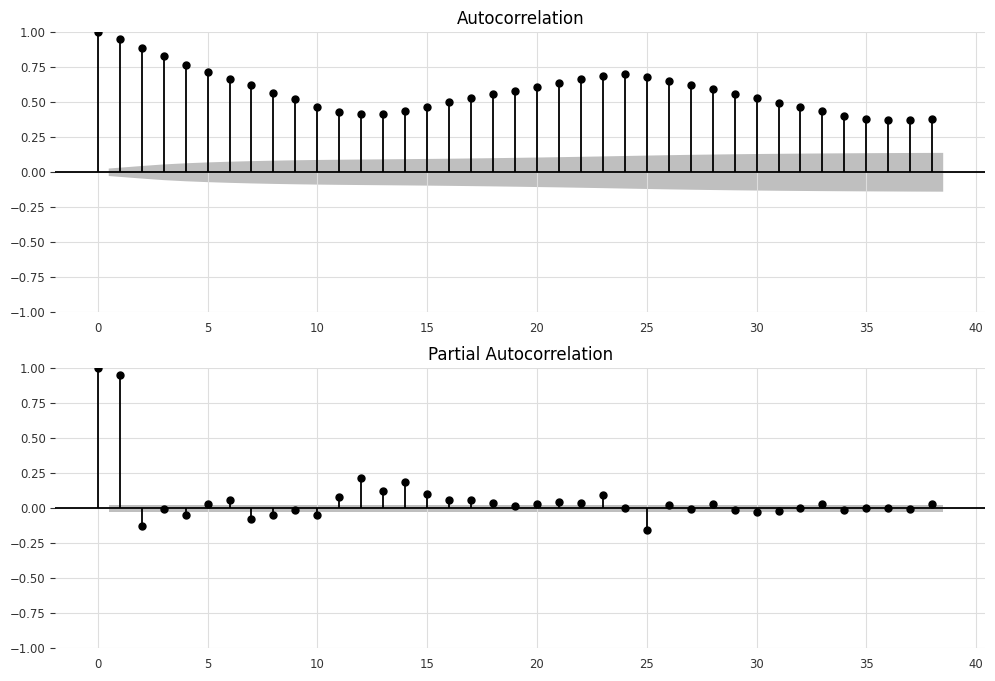

In [6]:
df = pd.read_csv('https://docs.google.com/uc?export=download&id=1-F71fdeBhScnn01Ev78BGc-ZLGr_WHJR')

df['Data'] = pd.to_datetime(df['Data'])
data = df['total_w']
import pandas as pd
import xarray as xr

# Supondo que você tenha um DataFrame chamado df com as colunas 'Data' e 'total_w'

# Primeiro, converta a coluna 'Data' para o tipo datetime
df['Data'] = pd.to_datetime(df['Data'])

# Em seguida, defina o índice do DataFrame como a coluna 'Data'
df.set_index('Data', inplace=True)

# Crie o objeto TimeSeries (DataArray) a partir do DataFrame
time_series = xr.DataArray(df['total_w'])

# O objeto time_series agora é um DataArray onde as datas são os índices.
# Plotar gráficos de autocorrelação e autocorrelação parcial
fig, ax = plt.subplots(2,1,figsize=(12,8))
plot_acf(data, ax=ax[0])
plot_pacf(data, ax=ax[1])
plt.show()

In [7]:
train,test = split_train_test(df,'2023-07-31 23:00:00','2023-08-01 00:00:00')

In [8]:
from darts.datasets import AirPassengersDataset
from darts.models import ARIMA
from darts.utils.timeseries_generation import datetime_attribute_timeseries
series_ts = TimeSeries.from_series(train['total_w'])
series = series_ts
future_cov = datetime_attribute_timeseries(series, "hour", cyclic=True, add_length=test.shape[0])
# define ARIMA parameters
model = ARIMA(p=0, d=1, q=0)
model.fit(series, future_covariates=future_cov)
capturar_uso_memoria()
pred = model.predict(test.shape[0], future_covariates=future_cov)
pred.values()

array([[905.07206712],
       [902.61834259],
       [903.40620243],
       [907.38195528],
       [914.27466017],
       [923.61459063],
       [934.76524585],
       [946.9667271 ],
       [959.3875236 ],
       [971.18117859],
       [981.54397397],
       [989.76970237],
       [995.29779398],
       [997.75151851],
       [996.96365867],
       [992.98790581],
       [986.09520093],
       [976.75527047],
       [965.60461525],
       [953.40313399],
       [940.9823375 ],
       [929.18868251],
       [918.82588713],
       [910.60015873],
       [905.07206712],
       [902.61834259],
       [903.40620243],
       [907.38195528],
       [914.27466017],
       [923.61459063],
       [934.76524585],
       [946.9667271 ],
       [959.3875236 ],
       [971.18117859],
       [981.54397397],
       [989.76970237],
       [995.29779398],
       [997.75151851],
       [996.96365867],
       [992.98790581],
       [986.09520093],
       [976.75527047],
       [965.60461525],
       [953

In [9]:
observed_values = test['total_w']
predicted_values = pred.values().flatten()
rmse, mse, mae, mape, r2, mase, smape = calculate_arima_metrics(observed_values, predicted_values)
print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)
print("MAPE:", mape)
print("R²:", r2)
print("MASE:", mase)
print("sMAPE:", smape)
print('Memoria RAM:',max(memoria_usada))

RMSE: 341.8671658166109
MSE: 116873.15906348215
MAE: 247.33807291976794
MAPE: 19.653460877115617
R²: -0.16254749086415776
MASE: inf
sMAPE: 21.87070502997176
Memoria RAM: 1251401728
